In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import metapack as mp
from pathlib import Path
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.display import display

import numpy as np
import statsmodels.api as sm

lowess = sm.nonparametric.lowess

%run ./lib.py


age_duration = {
    '-35': 12,    # 1
    '35-44': 10,  # 2 
    '45-54': 10,  # 3
    '55-64': 10 , # 4
    '65-74': 0,   # 5
    '75+': 0      # 6
}

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()

source = "Survey of Consumer Finances, 2016 and 2019 pooled"


In [2]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
display(pkg)
display(pkg.reference('scf').resolved_url.doc)

# Survey of Consumer Finances, Inheritance Extract
`federalreserve.gov-consumer_finances-2016e2019-inherit-1.2.3` Last Update: 2020-11-14T20:14:07

_An Extract from the survey of consumer finances for studying networth and ineritance, from multiple years_


This is an extract of the 2016 and 2019 Survey of Consumer Finances, with extracted variables
and recoded variables oriented toward studying inheritance.


 
## Images

[![doc_img](docs/networth_race_inc.png "networth_race_inc")](docs/networth_race_inc.png)

Net Worth by Income Percentile and Race## Notes

* Version 1.2.2 Added the Inflatable flag
* Version 1.2.3 Inflated dollar ammounts to current dollars
## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [inherit_scf_16_19](data/inherit_scf_16_19.csv)**. Extract of the 2016 and 2019 SCF for inheritance and networth

## References
<ul><li> <strong>scf</string>, <em>metapack+http://library.metatab.org/federalreserve.gov-consumer_finances-1.1.1.csv</em>. Survey of consumer finances data packages</li><li> <strong><a href="https://fred.stlouisfed.org/graph/fredgraph.csv?&id=CPIAUCSL">cpi</a></strong>. Consumer Price Index</li><ul>

# Survey of Consumer Finances
`federalreserve.gov-consumer_finances-1.1.1` Last Update: 2020-11-11T20:39:32

_References to the Survey of Consumer Finances_


The data package provides references to the main SCF files for the years 2016 and 2019. The package does not contain data, but rather is intended to be used with Metatab to build data extract packages. 


# References

* [How Does Intergenerational Wealth Transmission Affect Wealth Concentration? ](https://www.federalreserve.gov/econres/notes/feds-notes/how-does-intergenerational-wealth-transmission-affect-wealth-concentration-20180601.htm)
* [The Dynamics of the Racial Wealth Gap](http://www.people.virginia.edu/~ey2d/aliprantis_carroll_young_2019b.pdf)

Feiveson and Sabelhaus calculate that 26% of wealth is due to transfers, because they assume that all of the transfer is invested at 3%. This is clearly nonsense
## Documentation Links

* [Codebook, 2016](https://www.federalreserve.gov/econres/files/codebk2016.txt) 
* [Codebook, 2019](https://www.federalreserve.gov/econres/files/codebk2019.txt) 
* [Extract file macro](https://www.federalreserve.gov/econres/files/bulletin.macro.txt) 
* [Documentation Page](http://library.metatab.org/federalreserve.gov-consumer_finances-1.1.1/index.html) 
* [Homepage](https://www.federalreserve.gov/econres/scfindex.htm) 

 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)


## References
<ul><li> <strong><a href="https://www.federalreserve.gov/econres/files/scf2016s.zip#p16i6.dta">scf_public_16</a></strong>. Survey of consumer finances, full public dataset, 2016</li><li> <strong><a href="https://www.federalreserve.gov/econres/files/scfp2016s.zip#rscfp2016.dta">scf_extract_16</a></strong>. Survey of consumer finances, public extract, 2016</li><li> <strong><a href="https://www.federalreserve.gov/econres/files/scf2016rw1s.zip#p16_rw1.dta">scf_weights_16</a></strong>. Survey of consumer finances, replicate weights, 2016</li><li> <strong><a href="https://www.federalreserve.gov/econres/files/scf2019s.zip">scf_public_19</a></strong>. Survey of consumer finances, full public dataset, 2019</li><li> <strong><a href="https://www.federalreserve.gov/econres/files/scfp2019s.zip">scf_extract_19</a></strong>. Survey of consumer finances, public extract, 2019</li><li> <strong><a href="https://www.federalreserve.gov/econres/files/scf2019rw1s.zip">scf_weights_19</a></strong>. Survey of consumer finances, replicate weights, 2019</li><ul>

In [3]:
df = pkg.resource('inherit_scf_16_19').dataframe()
df = df[df.race.isin(['white','black'])]

# Count parent's bachelors degrees

def count_bach(r):
    return \
        int(r.ed_father_1 == 'bachelors') + \
        int(r.ed_father_2 == 'bachelors') + \
        int(r.ed_mother_1 == 'bachelors') + \
        int(r.ed_mother_2 == 'bachelors')
 
df['n_bach'] = df.apply(count_bach, axis=1)
df['agecl'] = df.agecl.astype(pd.CategoricalDtype([ '<35', '35-44', '45-54', '55-64', '65-74', '>=75',], ordered=True))

df['edcl'] = df.edcl.astype(pd.CategoricalDtype(['No HS', 'HS/GED', 'Some College', 'College'], ordered = True))

# Remap the nwpctlecat category numbers to percentile numbers
m = dict(zip(list(sorted(df.nwpctlecat.unique())),'0 10 20 30 40 50 60 70 80 90 95 99'.split()))
df['nwpctle'] = df.nwpctlecat.replace(m).astype(int)


#dfs = df.sample(500_000,replace=True, weights=df.wt0)
#dfs.head()

In [4]:
# Subtract out the effect of gifts/transfers
t = df[df.gi_sum != 0].copy()
t = t.groupby('record_id').sum()
t['networth_pv10'] = t.networth - t.gi_pv_10
t['networth_pv7'] = t.networth - t.gi_pv_7
t['networth_pv5'] = t.networth - t.gi_pv_5
t['networth_pv0'] = t.networth - t.gi_value_cd

cols = ['ninccat', 'networth_pv10', 'networth_pv7', 'networth_pv5', 'networth_pv0']

dfgi = df.merge(t[cols], on='record_id', how='left')

dfs = dfgi.sample(500_000,replace=True, weights=dfgi.wt0)
dfs.head()

,year,case_id,record_id,implicate_id,age_1,age_2,hisp,race,addtional_race,unusual_income,...,gi_pv_10,gi_pv_7,gi_pv_5,gi_value_cd,n_bach,ninccat_y,networth_pv10,networth_pv7,networth_pv5,networth_pv0
6851,2016,1618,16184,4,39,0,5,white,5,2,...,2914.312471,2163.535813,1773.116642,1275.457048,1,3,4.036697e+04,4.111774e+04,4.150816e+04,4.200582e+04
15847,2016,3719,37194,4,70,0,5,white,5,3,...,170043.443684,146512.229954,132635.716346,112666.219751,0,3,1.010940e+06,1.034471e+06,1.048348e+06,1.068317e+06
26082,2016,6144,61445,5,79,0,5,white,5,2,...,0.000000,0.000000,0.000000,0.000000,0,<NA>,NaN,NaN,NaN,NaN
9227,2016,2160,21601,1,60,0,5,white,5,2,...,0.000000,0.000000,0.000000,0.000000,0,6,2.879892e+06,3.075094e+06,3.176603e+06,3.305995e+06
21288,2016,5021,50211,1,26,0,5,black,5,3,...,0.000000,0.000000,0.000000,0.000000,0,<NA>,NaN,NaN,NaN,NaN


In [5]:
def make_gi_npv(df):
    '''Compute when people recieved a gift/transfer, and calculate the value in current dollars '''
    
    cpi = make_cpi(pkg).rename(columns={'year':'gi_year'})
    
    cols = [ ['record_id',  f'gi_from_{i}', f'gi_type_{i}',f'gi_value_{i}', f'gi_year_{i}' ] for i in (1,2,3)]

    # expand out each of the gi columns
    frames = []
    for c in cols:
        t = df[c]
        t.columns = ['record_id',  f'gi_from', f'gi_type',f'gi_value', f'gi_year' ]
        frames.append(t)


    t = pd.concat(frames, sort=False)
    t = t[t.gi_value > 0]
    t['nz'] = (t.gi_value > 0).fillna(0).astype(float)
    t = t.merge(df, on='record_id')
    t['gi_age'] = t.year - t.gi_year 
    t['age_at_gi'] = t.age_1 - t['gi_age']

    t['age_at_gi'] = (t.age_at_gi.mask( t.age_at_gi<0, np.nan)).astype('Int64')
    
    t = t.merge(cpi, on='gi_year')
    t['gi_value_cd'] = t.gi_value / t.cpi
    
    return t


aagi = make_gi_npv(df)
aagi['nz'] = aagi.nz.fillna(0)

aagi90 = aagi[ (aagi.nwpctle <= 90) & (aagi.nincpctle <= 90) ].copy() # Exclude those in top 10pct of gifts. 

a90 = aagi90.sample(1_000_000,replace=True, weights=aagi90.wt0)

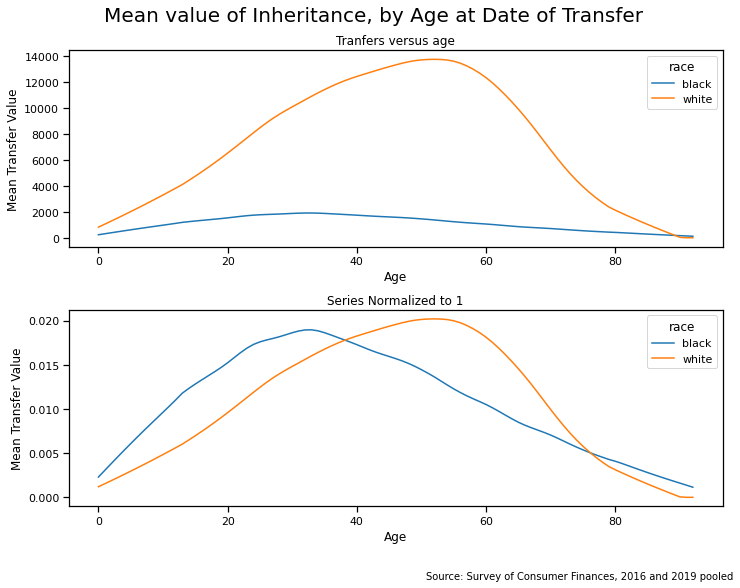

In [17]:
t = a90[a90.gi_type == 'inheritance']
t = t.groupby(['age_at_gi','race']).gi_value_cd.count()
t = t.unstack()
t.index = t.index.astype(int)
t = t.interpolate(method='quadratic').fillna(0)

t['white'] = pd.Series(lowess(t.white, t.index, frac=.3)[:,1],index=t.index)
t['black'] = pd.Series(lowess(t.black, t.index, frac=.3)[:,1],index=t.index)
t = t.clip(0)

with new_plot('Mean value of Inheritance, by Age at Date of Transfer', source,
             ylabel='Mean Transfer Value', xlabel='Age', panes=2) as (fig,ax):
    t.plot(ax=ax[0])
    ax[0].set_title('Tranfers versus age')
    (t/t.sum()).plot(ax=ax[1])
    ax[1].set_title('Series Normalized to 1')

       

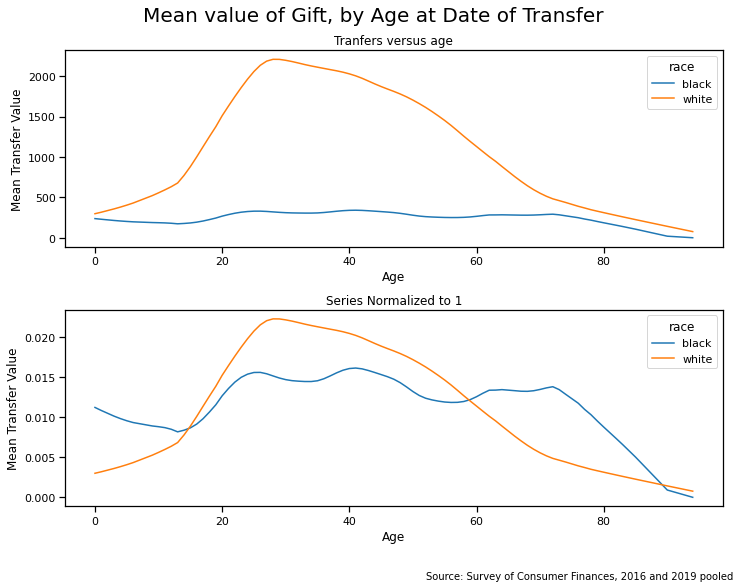

In [16]:
t = a90[a90.gi_type == 'gift']
t = t.groupby(['age_at_gi','race']).gi_value_cd.count()
t = t.unstack()
t.index = t.index.astype(int)
t = t.interpolate(method='quadratic').fillna(0)

t['white'] = pd.Series(lowess(t.white, t.index, frac=.3)[:,1],index=t.index)
t['black'] = pd.Series(lowess(t.black, t.index, frac=.3)[:,1],index=t.index)
t = t.clip(0)

with new_plot('Mean value of Gift, by Age at Date of Transfer', source,
             ylabel='Mean Transfer Value', xlabel='Age', panes=2) as (fig,ax):
    t.plot(ax=ax[0])
    ax[0].set_title('Tranfers versus age')
    (t/t.sum()).plot(ax=ax[1])
    ax[1].set_title('Series Normalized to 1')

       

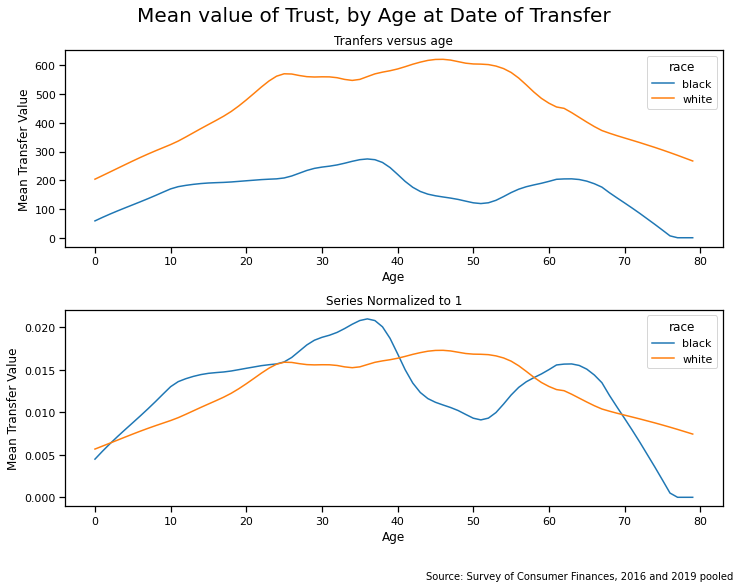

In [15]:
t = a90[a90.gi_type == 'trust']
t = t.groupby(['age_at_gi','race']).gi_value_cd.count()
t = t.unstack()
t.index = t.index.astype(int)
t = t.interpolate(method='quadratic').fillna(0)

t['white'] = pd.Series(lowess(t.white, t.index, frac=.3)[:,1],index=t.index)
t['black'] = pd.Series(lowess(t.black, t.index, frac=.3)[:,1],index=t.index)
t = t.clip(0)

with new_plot('Mean value of Trust, by Age at Date of Transfer', source,
             ylabel='Mean Transfer Value', xlabel='Age', panes=2) as (fig,ax):
    t.plot(ax=ax[0])
    ax[0].set_title('Tranfers versus age')
    (t/t.sum()).plot(ax=ax[1])
    ax[1].set_title('Series Normalized to 1')

       

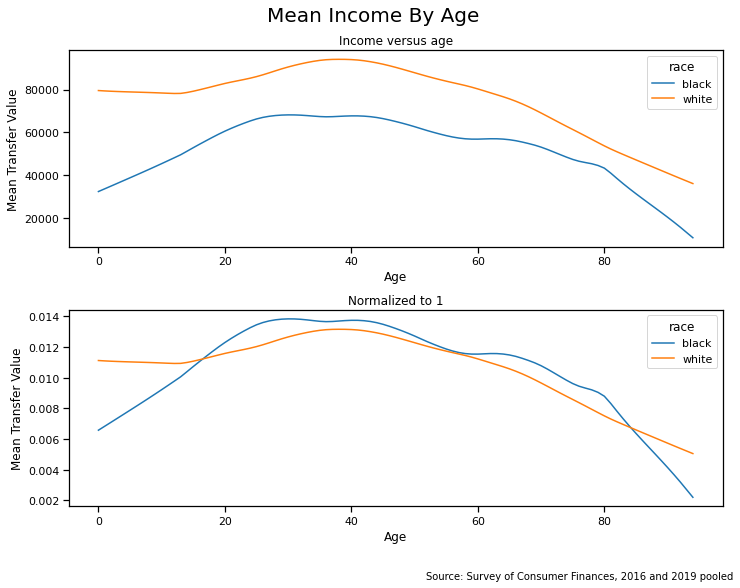

In [7]:
        
t = a90
t = t.groupby(['age_at_gi','race']).norminc.mean()
t = t.unstack()
t.index = t.index.astype(int)
t = t.interpolate(method='quadratic').fillna(0)
for c in t.columns:
    t[c] = pd.Series(lowess(t[c], t.index, frac=.3)[:,1],index=t.index)

t = t.clip(0)

with new_plot('Mean Income By Age', source,
             ylabel='Mean Transfer Value', xlabel='Age', panes=2) as (fig,ax):
    t.plot(ax=ax[0])
    ax[0].set_title('Income versus age')
    (t/t.sum()).plot(ax=ax[1])
    ax[1].set_title('Normalized to 1')

    

In [8]:
t = a90.groupby(['age_at_gi','race']).norminc.mean()
t = t.unstack()
t.index = t.index.astype(int)
t = t.interpolate(method='quadratic').fillna(0)
for c in t.columns:
    t[c] = pd.Series(lowess(t[c], t.index, frac=.3)[:,1],index=t.index)


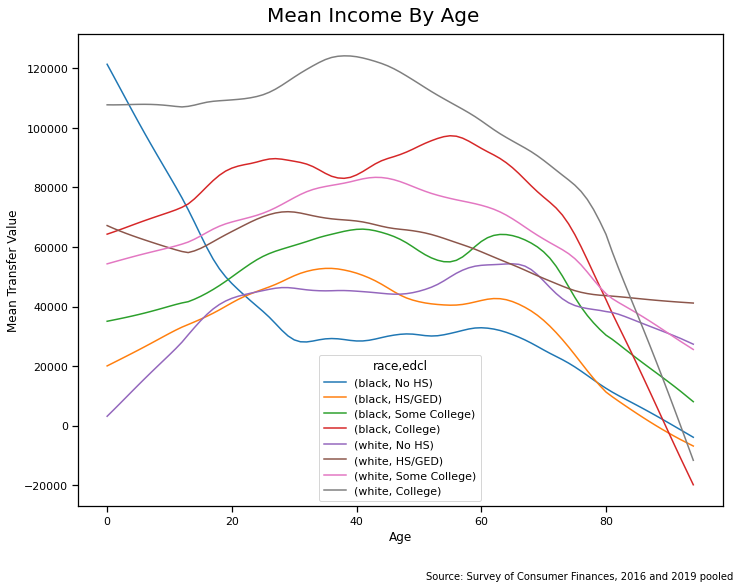

In [10]:
t = a90.groupby(['race', 'edcl','age_at_gi']).norminc.mean()
t = t.unstack().T
t.index = t.index.astype(int)
t = t.interpolate(method='quadratic').fillna(0)
for c in t.columns:
    t[c] = pd.Series(lowess(t[c], t.index, frac=.3)[:,1],index=t.index)
    
with new_plot('Mean Income By Age', source,
             ylabel='Mean Transfer Value', xlabel='Age') as (fig,ax):
    t.plot(ax=ax)